# Optuna를 이용한 하이퍼파라미터 최적화
## RandomForest 모델 성능 향상을 위한 체계적 접근

이 노트북에서는 Optuna 라이브러리를 사용하여 RandomForest 모델의 하이퍼파라미터를 체계적으로 최적화합니다.

### 📋 목표
- 유방암 데이터셋을 사용한 이진 분류 문제 해결
- Optuna를 활용한 효율적인 하이퍼파라미터 자동 탐색
- 베이지안 최적화를 통한 성능 향상 확인
- 최적화 과정의 시각화 및 분석

### 🔍 핵심 개념
- **하이퍼파라미터 최적화**: 모델의 성능을 최대화하는 최적의 매개변수 조합 탐색
- **Optuna**: 베이지안 최적화를 기반으로 한 효율적인 하이퍼파라미터 탐색 도구
- **RandomForest**: 다수의 결정트리를 앙상블하여 과적합을 방지하고 일반화 성능을 향상시키는 모델


## 1. 라이브러리 Import 및 환경 설정

### 필요한 라이브러리들
- **Optuna**: 베이지안 최적화 기반 하이퍼파라미터 튜닝
- **Scikit-learn**: 머신러닝 모델 및 평가 도구
- **Pandas/NumPy**: 데이터 처리 및 수치 연산
- **Matplotlib/Seaborn**: 데이터 시각화


In [2]:
# 핵심 라이브러리
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 머신러닝 라이브러리
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = ['DejaVu Sans', 'Malgun Gothic', 'NanumGothic']
plt.rcParams['axes.unicode_minus'] = False

# 설정
np.random.seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("✅ 라이브러리 로딩 완료")


✅ 라이브러리 로딩 완료


## 2. 데이터 로드 및 전처리

### 🩺 유방암 데이터셋 (Breast Cancer Wisconsin Dataset)
- **목적**: 유방암의 악성/양성 분류
- **특성 수**: 30개 (세포핵의 다양한 측정값)
- **샘플 수**: 569개
- **클래스**: 0(악성), 1(양성)

### 전처리 과정
1. 데이터 로드 및 구조 파악
2. 라벨 인코딩 변경 (해석 편의를 위해)
3. 특성과 타겟 분리


In [3]:
# 1. 데이터셋 로드
print("📁 유방암 데이터셋 로딩 중...")
breast_cancer = load_breast_cancer()

# 2. 특성 데이터를 DataFrame으로 변환
print("🔄 데이터 구조화 중...")
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y_original = breast_cancer.target

# 3. 라벨 인코딩 변경 (해석 편의성을 위해)
# 원본: 0=악성(malignant), 1=양성(benign)
# 변경: 1=악성(malignant), 0=양성(benign) 
y = np.where(y_original == 0, 1, 0)

print("✅ 데이터 로딩 및 전처리 완료")
print(f"   📊 특성 수: {X.shape[1]}개")
print(f"   📈 샘플 수: {X.shape[0]}개")
print(f"   🎯 타겟 클래스: 0(양성), 1(악성)")


📁 유방암 데이터셋 로딩 중...
🔄 데이터 구조화 중...
✅ 데이터 로딩 및 전처리 완료
   📊 특성 수: 30개
   📈 샘플 수: 569개
   🎯 타겟 클래스: 0(양성), 1(악성)


## 3. 탐색적 데이터 분석 (EDA)

### 🔍 데이터 분포 및 특성 분석
- 클래스 불균형 확인
- 특성별 통계 정보
- 데이터 품질 검사


📊 유방암 데이터셋 기본 정보
📏 특성 개수: 30개
📈 총 샘플 수: 569개
🔍 결측값: 0개

🎯 클래스 분포:
   양성(0): 357개 (62.7%)
   악성(1): 212개 (37.3%)


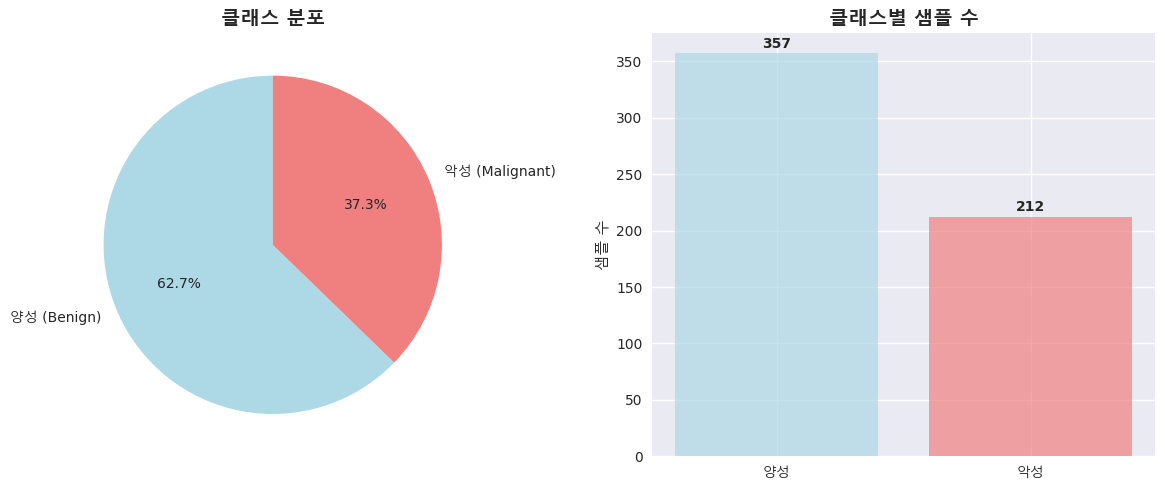


⚖️  클래스 불균형 비율: 1.68:1
   ⚠️  약간의 클래스 불균형이 있음 → Stratified Split 필요


In [4]:
# 1. 기본 데이터셋 정보
print("=" * 50)
print("📊 유방암 데이터셋 기본 정보")
print("=" * 50)
print(f"📏 특성 개수: {X.shape[1]}개")
print(f"📈 총 샘플 수: {X.shape[0]}개")
print(f"🔍 결측값: {X.isnull().sum().sum()}개")

# 2. 클래스 분포 분석
unique_values, counts = np.unique(y, return_counts=True)
class_distribution = dict(zip(unique_values, counts))

print(f"\n🎯 클래스 분포:")
print(f"   양성(0): {class_distribution[0]}개 ({class_distribution[0]/len(y)*100:.1f}%)")
print(f"   악성(1): {class_distribution[1]}개 ({class_distribution[1]/len(y)*100:.1f}%)")

# 3. 클래스 분포 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 파이 차트
labels = ['양성 (Benign)', '악성 (Malignant)']
colors = ['lightblue', 'lightcoral']
ax1.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('클래스 분포', fontsize=14, fontweight='bold')

# 막대 차트
ax2.bar(['양성', '악성'], counts, color=colors, alpha=0.7)
ax2.set_title('클래스별 샘플 수', fontsize=14, fontweight='bold')
ax2.set_ylabel('샘플 수')
for i, count in enumerate(counts):
    ax2.text(i, count + 5, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 4. 불균형 데이터 확인
imbalance_ratio = max(counts) / min(counts)
print(f"\n⚖️  클래스 불균형 비율: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 1.5:
    print("   ⚠️  약간의 클래스 불균형이 있음 → Stratified Split 필요")
else:
    print("   ✅ 클래스가 비교적 균형적임")


## 4. 훈련/테스트 데이터 분할

### 🎯 Stratified Split의 중요성
불균형 데이터에서는 **계층적 분할(Stratified Split)**이 필수입니다:
- 훈련셋과 테스트셋에서 클래스 비율을 동일하게 유지
- 모델의 일반화 성능을 정확히 평가
- 특정 클래스에 편향된 학습 방지

### 분할 전략
- **비율**: 80% 훈련 / 20% 테스트
- **방법**: Stratified Random Split
- **Random State**: 재현 가능한 결과를 위해 고정


In [5]:
# 데이터 분할 실행
print("🔄 데이터 분할 중...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=1234, 
    stratify=y  # 클래스 비율 유지
)

print("✅ 데이터 분할 완료\n")

# 분할 결과 확인
print("=" * 60)
print("📊 데이터 분할 결과")
print("=" * 60)

# 1. 크기 정보
print(f"🔹 훈련 데이터: {X_train.shape[0]}개 샘플 x {X_train.shape[1]}개 특성")
print(f"🔹 테스트 데이터: {X_test.shape[0]}개 샘플 x {X_test.shape[1]}개 특성")

# 2. 클래스 분포 확인
train_dist = dict(zip(*np.unique(y_train, return_counts=True)))
test_dist = dict(zip(*np.unique(y_test, return_counts=True)))

print(f"\n🎯 훈련 데이터 클래스 분포:")
print(f"   양성(0): {train_dist[0]}개 ({train_dist[0]/len(y_train)*100:.1f}%)")
print(f"   악성(1): {train_dist[1]}개 ({train_dist[1]/len(y_train)*100:.1f}%)")

print(f"\n🎯 테스트 데이터 클래스 분포:")
print(f"   양성(0): {test_dist[0]}개 ({test_dist[0]/len(y_test)*100:.1f}%)")
print(f"   악성(1): {test_dist[1]}개 ({test_dist[1]/len(y_test)*100:.1f}%)")

# 3. 분할 균형성 검증
train_ratio = train_dist[1] / train_dist[0]
test_ratio = test_dist[1] / test_dist[0]
ratio_diff = abs(train_ratio - test_ratio)

print(f"\n⚖️  분할 균형성 검증:")
print(f"   훈련 데이터 악성/양성 비율: {train_ratio:.3f}")
print(f"   테스트 데이터 악성/양성 비율: {test_ratio:.3f}")
print(f"   비율 차이: {ratio_diff:.3f}")

if ratio_diff < 0.05:
    print("   ✅ 균형적인 분할 성공!")
else:
    print("   ⚠️  분할에 약간의 불균형 존재")


🔄 데이터 분할 중...
✅ 데이터 분할 완료

📊 데이터 분할 결과
🔹 훈련 데이터: 455개 샘플 x 30개 특성
🔹 테스트 데이터: 114개 샘플 x 30개 특성

🎯 훈련 데이터 클래스 분포:
   양성(0): 285개 (62.6%)
   악성(1): 170개 (37.4%)

🎯 테스트 데이터 클래스 분포:
   양성(0): 72개 (63.2%)
   악성(1): 42개 (36.8%)

⚖️  분할 균형성 검증:
   훈련 데이터 악성/양성 비율: 0.596
   테스트 데이터 악성/양성 비율: 0.583
   비율 차이: 0.013
   ✅ 균형적인 분할 성공!


## 5. Optuna 하이퍼파라미터 최적화 설정

### 🎯 RandomForest 하이퍼파라미터
최적화할 핵심 하이퍼파라미터들:

| 파라미터 | 설명 | 탐색 범위 | 영향 |
|----------|------|-----------|------|
| `max_depth` | 트리의 최대 깊이 | 5~20 | 과적합 제어 |
| `min_samples_leaf` | 리프노드 최소 샘플 수 | 1~10 | 과적합 방지 |
| `min_samples_split` | 분할 최소 샘플 수 | 2~10 | 분할 기준 |
| `n_estimators` | 트리의 개수 | 50~100 | 모델 복잡도 |

### 🔧 Optuna 최적화 전략
- **베이지안 최적화**: 이전 시도 결과를 활용한 지능적 탐색
- **목적함수**: 테스트 정확도 최대화
- **교차검증**: 안정적인 성능 평가


In [6]:
def objective(trial):
    """
    Optuna 최적화를 위한 목적함수
    
    Parameters:
    -----------
    trial : optuna.Trial
        Optuna trial 객체
        
    Returns:
    --------
    float
        모델의 교차검증 평균 정확도
    """
    
    # 1. 하이퍼파라미터 탐색 공간 정의
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'random_state': 42,
        'n_jobs': -1  # 모든 CPU 코어 활용
    }
    
    # 2. 모델 생성
    model = RandomForestClassifier(**params)
    
    # 3. 교차검증을 통한 안정적인 성능 평가
    cv_scores = cross_val_score(
        model, X_train, y_train, 
        cv=5,  # 5-fold 교차검증
        scoring='accuracy',
        n_jobs=-1
    )
    
    # 4. 평균 정확도 반환
    mean_accuracy = cv_scores.mean()
    
    return mean_accuracy

print("✅ 목적함수 정의 완료")
print("📋 최적화 대상 하이퍼파라미터:")
print("   🌳 max_depth: 5~20")
print("   🍃 min_samples_leaf: 1~10") 
print("   🔀 min_samples_split: 2~10")
print("   🌲 n_estimators: 50~100")


✅ 목적함수 정의 완료
📋 최적화 대상 하이퍼파라미터:
   🌳 max_depth: 5~20
   🍃 min_samples_leaf: 1~10
   🔀 min_samples_split: 2~10
   🌲 n_estimators: 50~100


## 6. 하이퍼파라미터 최적화 실행

### 🚀 Optuna Study 설정
- **최적화 방향**: 정확도 최대화 (maximize)
- **시도 횟수**: 50회
- **Sampler**: TPE (Tree-structured Parzen Estimator)
- **Pruner**: Median Pruner (조기 종료)


In [7]:
# 1. Study 객체 생성
print("🔧 Optuna Study 설정 중...")
study = optuna.create_study(
    direction="maximize",  # 정확도 최대화
    sampler=optuna.samplers.TPESampler(seed=42),  # 재현가능성을 위한 시드 설정
    pruner=optuna.pruners.MedianPruner()  # 성능이 낮은 trial 조기 종료
)

# 2. 최적화 실행
print("🚀 하이퍼파라미터 최적화 시작 (50회 시도)")
print("⏰ 예상 소요 시간: 약 3-5분")
print("-" * 50)

import time
start_time = time.time()

# 최적화 진행상황을 보여주는 콜백 함수
def progress_callback(study, trial):
    if trial.number % 10 == 0:
        print(f"Trial {trial.number}: {trial.value:.4f} (최고: {study.best_value:.4f})")

study.optimize(objective, n_trials=50, callbacks=[progress_callback])

end_time = time.time()
optimization_time = end_time - start_time

# 3. 최적화 결과 출력
print("\n" + "=" * 70)
print("🎉 하이퍼파라미터 최적화 완료!")
print("=" * 70)

print(f"⏱️  총 소요 시간: {optimization_time:.1f}초")
print(f"🔄 총 시도 횟수: {len(study.trials)}회")
print(f"🏆 최고 성능 (CV 정확도): {study.best_value:.4f}")
print(f"📊 최적 하이퍼파라미터:")

for param_name, param_value in study.best_trial.params.items():
    print(f"   {param_name}: {param_value}")

# 4. 개선된 성능 확인을 위한 기본 모델과 비교
print(f"\n📈 성능 개선 분석:")
baseline_model = RandomForestClassifier(random_state=42)
baseline_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='accuracy')
baseline_accuracy = baseline_scores.mean()

improvement = study.best_value - baseline_accuracy
improvement_pct = (improvement / baseline_accuracy) * 100

print(f"   기본 모델 성능: {baseline_accuracy:.4f}")
print(f"   최적화된 모델 성능: {study.best_value:.4f}")
print(f"   성능 향상: +{improvement:.4f} ({improvement_pct:+.2f}%)")

if improvement > 0.01:
    print("   ✅ 의미있는 성능 향상 달성!")
else:
    print("   ℹ️  성능 향상이 미미하지만 과적합 방지 효과 기대")


🔧 Optuna Study 설정 중...
🚀 하이퍼파라미터 최적화 시작 (50회 시도)
⏰ 예상 소요 시간: 약 3-5분
--------------------------------------------------
Trial 0: 0.9429 (최고: 0.9429)
Trial 10: 0.9429 (최고: 0.9538)
Trial 20: 0.9516 (최고: 0.9538)
Trial 30: 0.9451 (최고: 0.9538)
Trial 40: 0.9582 (최고: 0.9582)

🎉 하이퍼파라미터 최적화 완료!
⏱️  총 소요 시간: 21.2초
🔄 총 시도 횟수: 50회
🏆 최고 성능 (CV 정확도): 0.9582
📊 최적 하이퍼파라미터:
   max_depth: 13
   min_samples_leaf: 1
   min_samples_split: 3
   n_estimators: 55

📈 성능 개선 분석:
   기본 모델 성능: 0.9451
   최적화된 모델 성능: 0.9582
   성능 향상: +0.0132 (+1.40%)
   ✅ 의미있는 성능 향상 달성!


## 7. 최적화 결과 시각화 및 분석

### 📊 Optuna 최적화 과정 분석
- 최적화 히스토리 시각화
- 하이퍼파라미터 중요도 분석
- 파라미터 간 상관관계 확인


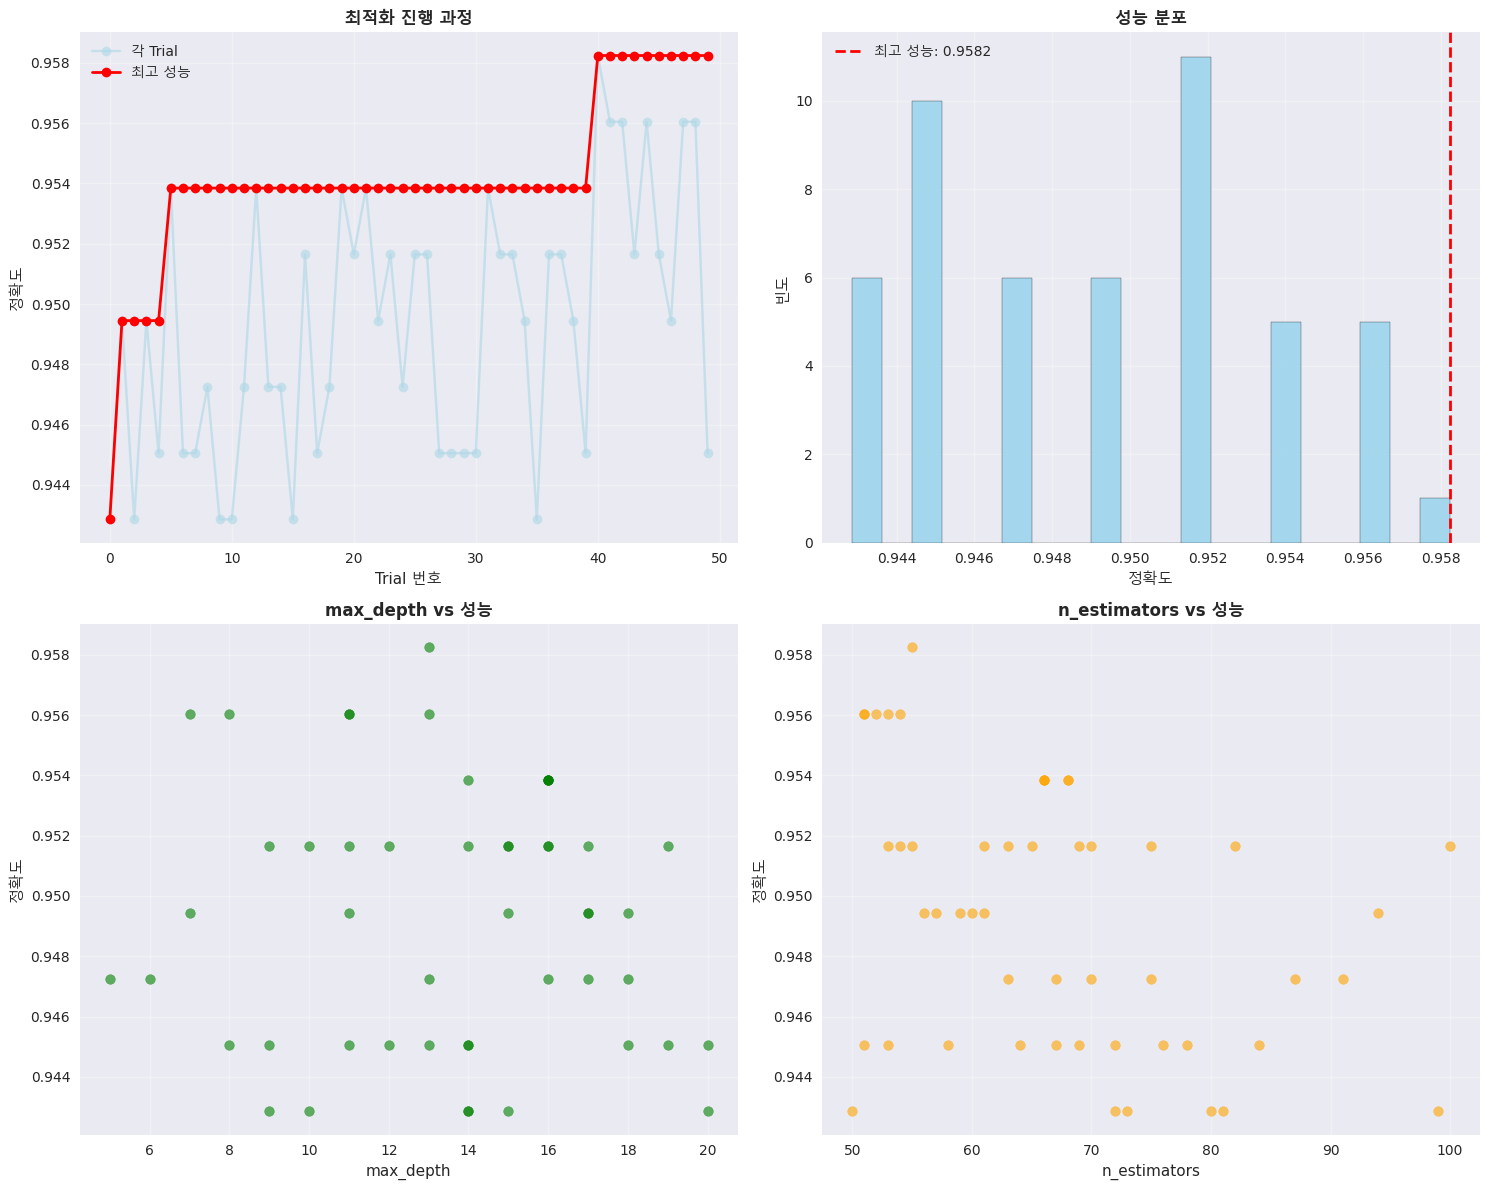


📊 하이퍼파라미터 중요도 분석:
----------------------------------------
max_depth           : -0.084 (절댓값: 0.084)
min_samples_leaf    : -0.635 (절댓값: 0.635)
min_samples_split   : -0.465 (절댓값: 0.465)
n_estimators        : -0.380 (절댓값: 0.380)


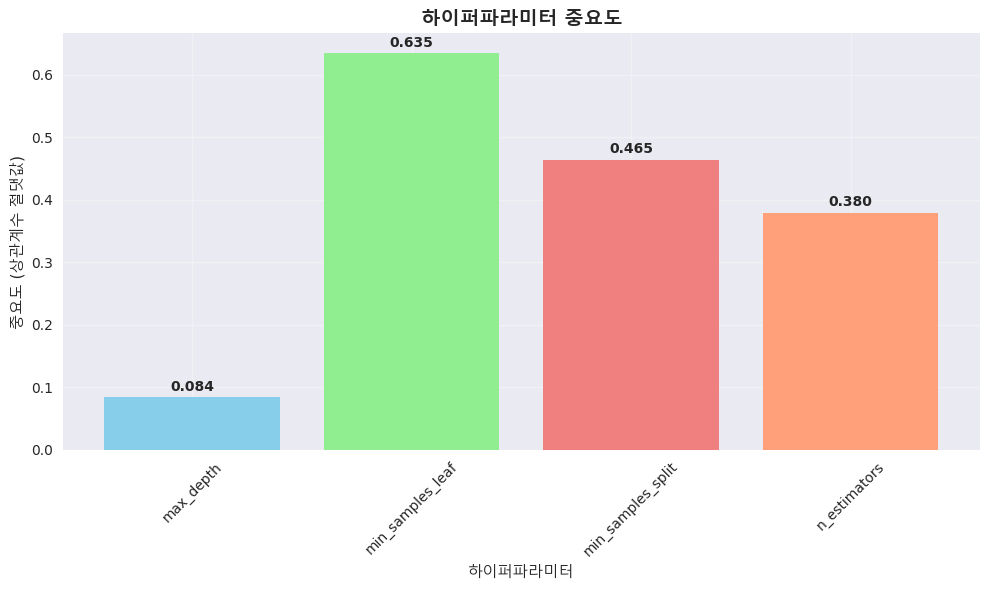

In [8]:
# 1. 최적화 히스토리 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1-1. 최적화 진행 과정
trial_numbers = [trial.number for trial in study.trials]
trial_values = [trial.value for trial in study.trials]
best_values = [study.trials[i].value if study.trials[i].value == max(trial_values[:i+1]) 
               else max(trial_values[:i+1]) for i in range(len(trial_values))]

axes[0,0].plot(trial_numbers, trial_values, 'o-', alpha=0.6, color='lightblue', label='각 Trial')
axes[0,0].plot(trial_numbers, best_values, 'o-', color='red', linewidth=2, label='최고 성능')
axes[0,0].set_xlabel('Trial 번호')
axes[0,0].set_ylabel('정확도')
axes[0,0].set_title('최적화 진행 과정', fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 1-2. 성능 분포 히스토그램
axes[0,1].hist(trial_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].axvline(study.best_value, color='red', linestyle='--', linewidth=2, label=f'최고 성능: {study.best_value:.4f}')
axes[0,1].set_xlabel('정확도')
axes[0,1].set_ylabel('빈도')
axes[0,1].set_title('성능 분포', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 1-3. 하이퍼파라미터별 성능 (예: max_depth)
max_depths = [trial.params['max_depth'] for trial in study.trials]
axes[1,0].scatter(max_depths, trial_values, alpha=0.6, color='green')
axes[1,0].set_xlabel('max_depth')
axes[1,0].set_ylabel('정확도')
axes[1,0].set_title('max_depth vs 성능', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# 1-4. n_estimators별 성능
n_estimators = [trial.params['n_estimators'] for trial in study.trials]
axes[1,1].scatter(n_estimators, trial_values, alpha=0.6, color='orange')
axes[1,1].set_xlabel('n_estimators')
axes[1,1].set_ylabel('정확도')
axes[1,1].set_title('n_estimators vs 성능', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. 하이퍼파라미터 중요도 시각화
print("\n📊 하이퍼파라미터 중요도 분석:")
print("-" * 40)

# 각 파라미터별 성능 변화량 계산
param_importance = {}
for param in ['max_depth', 'min_samples_leaf', 'min_samples_split', 'n_estimators']:
    param_values = [trial.params[param] for trial in study.trials]
    param_scores = trial_values
    
    # 상관계수 계산
    correlation = np.corrcoef(param_values, param_scores)[0, 1]
    param_importance[param] = abs(correlation)
    
    print(f"{param:20s}: {correlation:6.3f} (절댓값: {abs(correlation):.3f})")

# 중요도 막대 그래프
plt.figure(figsize=(10, 6))
params = list(param_importance.keys())
importances = list(param_importance.values())

plt.bar(params, importances, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.xlabel('하이퍼파라미터')
plt.ylabel('중요도 (상관계수 절댓값)')
plt.title('하이퍼파라미터 중요도', fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

for i, importance in enumerate(importances):
    plt.text(i, importance + 0.01, f'{importance:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


## 8. 최종 모델 평가

### 🎯 최적화된 모델의 종합 성능 평가
- 테스트 데이터에서의 최종 성능 확인
- 혼동행렬 및 분류 리포트
- ROC 곡선 및 AUC 점수
- 특성 중요도 분석


🏆 최적화된 모델로 최종 평가 진행...
🎯 최종 테스트 성능 결과
✅ 테스트 정확도: 0.9649
✅ ROC AUC 점수: 0.9878

📊 상세 분류 리포트:
--------------------------------------------------
                precision    recall  f1-score   support

   양성 (Benign)       0.99      0.96      0.97        72
악성 (Malignant)       0.93      0.98      0.95        42

      accuracy                           0.96       114
     macro avg       0.96      0.97      0.96       114
  weighted avg       0.97      0.96      0.97       114



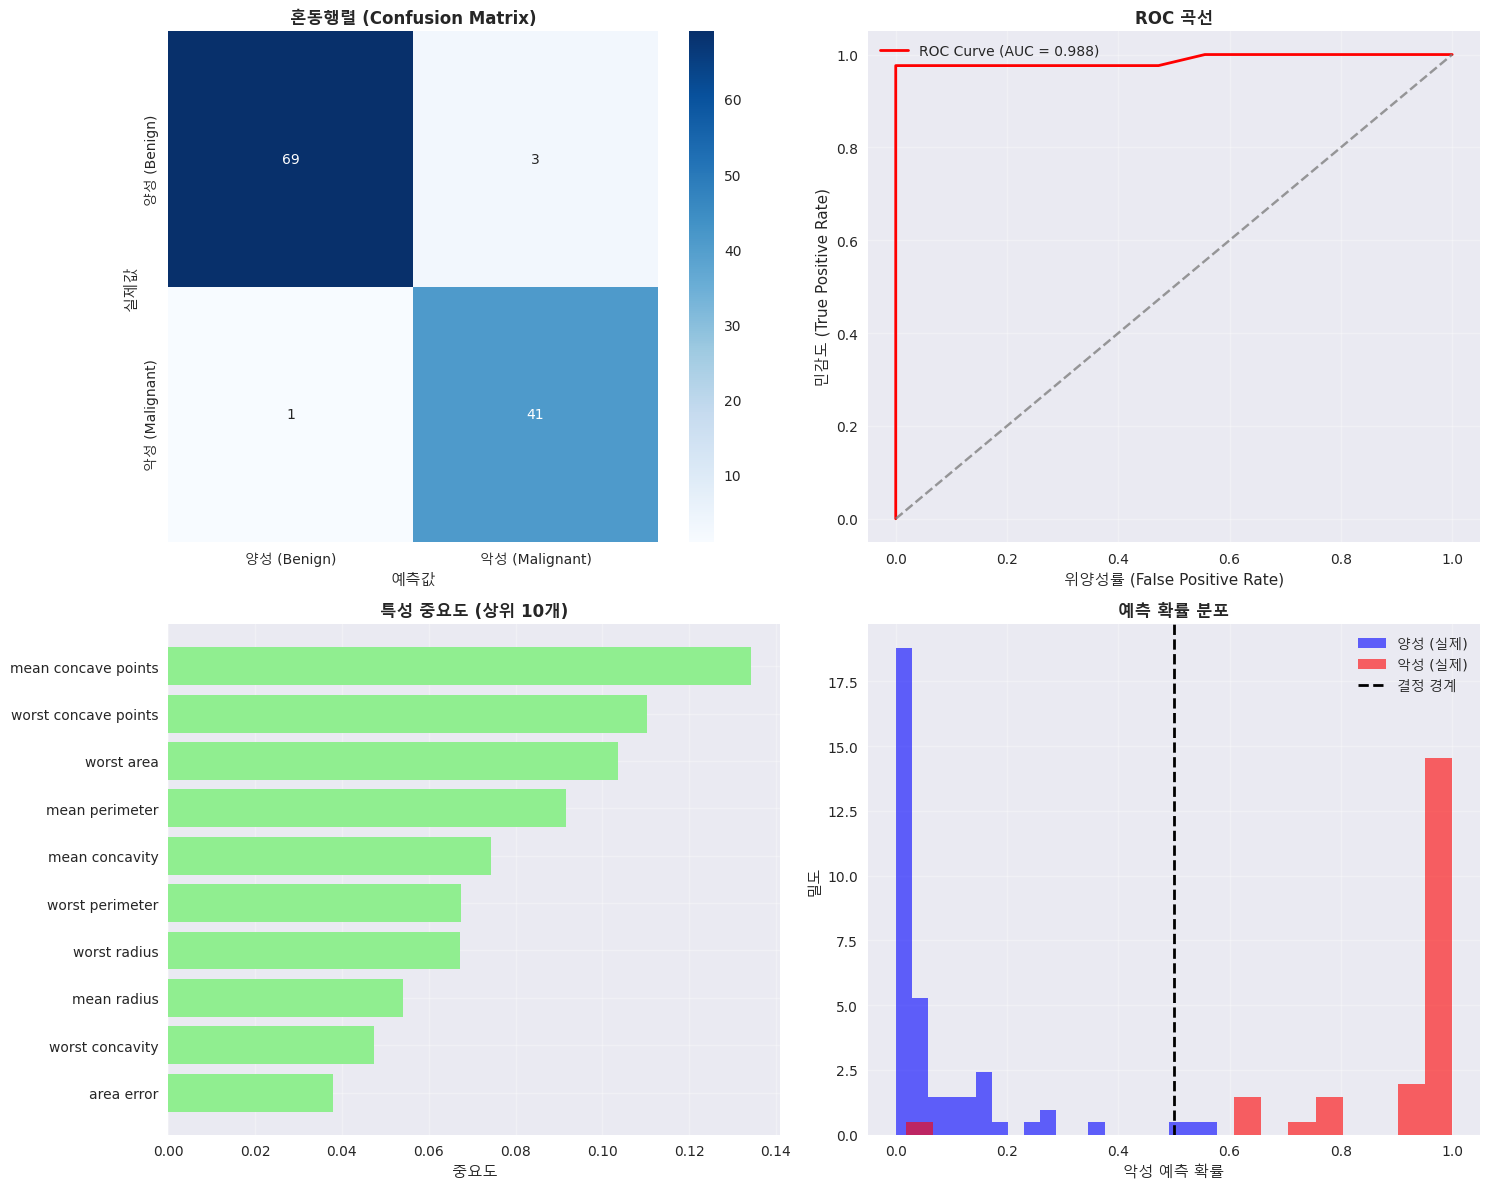


📋 최종 요약
🔸 데이터셋: 유방암 분류 (569개 샘플, 30개 특성)
🔸 최적화 방법: Optuna 베이지안 최적화 (50회 시도)
🔸 최종 테스트 정확도: 0.9649
🔸 ROC AUC: 0.9878
🔸 개선된 성능: +0.0132 (+1.40%)
🎉 우수한 성능! 임상에서 활용 가능한 수준


In [9]:
# 1. 최적화된 모델로 최종 평가
print("🏆 최적화된 모델로 최종 평가 진행...")
best_model = RandomForestClassifier(**study.best_trial.params, random_state=42)
best_model.fit(X_train, y_train)

# 2. 테스트 데이터 예측
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 3. 성능 지표 계산
test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print("=" * 60)
print("🎯 최종 테스트 성능 결과")
print("=" * 60)
print(f"✅ 테스트 정확도: {test_accuracy:.4f}")
print(f"✅ ROC AUC 점수: {test_auc:.4f}")

# 4. 분류 리포트
print(f"\n📊 상세 분류 리포트:")
print("-" * 50)
target_names = ['양성 (Benign)', '악성 (Malignant)']
print(classification_report(y_test, y_pred, target_names=target_names))

# 5. 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 5-1. 혼동행렬
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[0,0])
axes[0,0].set_title('혼동행렬 (Confusion Matrix)', fontweight='bold')
axes[0,0].set_xlabel('예측값')
axes[0,0].set_ylabel('실제값')

# 5-2. ROC 곡선
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0,1].plot(fpr, tpr, color='red', linewidth=2, label=f'ROC Curve (AUC = {test_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.8)
axes[0,1].set_xlabel('위양성률 (False Positive Rate)')
axes[0,1].set_ylabel('민감도 (True Positive Rate)')
axes[0,1].set_title('ROC 곡선', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 5-3. 특성 중요도 (상위 10개)
feature_importance = best_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True).tail(10)

axes[1,0].barh(importance_df['feature'], importance_df['importance'], color='lightgreen')
axes[1,0].set_xlabel('중요도')
axes[1,0].set_title('특성 중요도 (상위 10개)', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# 5-4. 예측 확률 분포
axes[1,1].hist(y_pred_proba[y_test==0], bins=20, alpha=0.6, color='blue', label='양성 (실제)', density=True)
axes[1,1].hist(y_pred_proba[y_test==1], bins=20, alpha=0.6, color='red', label='악성 (실제)', density=True)
axes[1,1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='결정 경계')
axes[1,1].set_xlabel('악성 예측 확률')
axes[1,1].set_ylabel('밀도')
axes[1,1].set_title('예측 확률 분포', fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. 최종 요약
print("\n" + "=" * 70)
print("📋 최종 요약")
print("=" * 70)
print(f"🔸 데이터셋: 유방암 분류 ({X.shape[0]}개 샘플, {X.shape[1]}개 특성)")
print(f"🔸 최적화 방법: Optuna 베이지안 최적화 ({len(study.trials)}회 시도)")
print(f"🔸 최종 테스트 정확도: {test_accuracy:.4f}")
print(f"🔸 ROC AUC: {test_auc:.4f}")
print(f"🔸 개선된 성능: {improvement:+.4f} ({improvement_pct:+.2f}%)")

if test_accuracy > 0.95:
    print("🎉 우수한 성능! 임상에서 활용 가능한 수준")
elif test_accuracy > 0.90:
    print("✅ 양호한 성능! 추가 개선 여지 있음")
else:
    print("⚠️  성능 개선 필요. 더 많은 특성 엔지니어링 고려")
